# Machine Learning Udacity Capstone Project
**"Sentiment analysis in airline tweets"**

Author: Luis Bronchal<br>Date: September 11, 2017

# Exploratory Data Analysis

## Summary

Basic EDA of the dataset [Twitter US Airline Sentiment](https://www.kaggle.com/crowdflower/twitter-airline-sentiment). We have cleaned and stored the output data to be used in the rest of the notebooks of the capstone.


## Data loading and cleaning

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv("../input/Tweets.csv")

In [3]:
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
tweet_id                        14640 non-null int64
airline_sentiment               14640 non-null object
airline_sentiment_confidence    14640 non-null float64
negativereason                  9178 non-null object
negativereason_confidence       10522 non-null float64
airline                         14640 non-null object
airline_sentiment_gold          40 non-null object
name                            14640 non-null object
negativereason_gold             32 non-null object
retweet_count                   14640 non-null int64
text                            14640 non-null object
tweet_coord                     1019 non-null object
tweet_created                   14640 non-null object
tweet_location                  9907 non-null object
user_timezone                   9820 non-null object
dtypes: float64(2), int64(2), object(11)
memory usage: 1.7+ MB


There are **14640 rows** and **15 variables**. We are interesed only in **text** variable which is the text of a tweet and **airline_sentiment** variable which is the sentiment associated to that tweet (the outcome variable to predict).

Each tweet from the dataset has been hand-labeled by a person. The variable **airline_sentiment_confidence** represents the reliability of the labeling. Because "garbage in, bargabe out" we are going to remove the less reliable tweets those with less than 0.65 reliability: 

In [5]:
np.sum(data['airline_sentiment_confidence'] < 0.65)

977

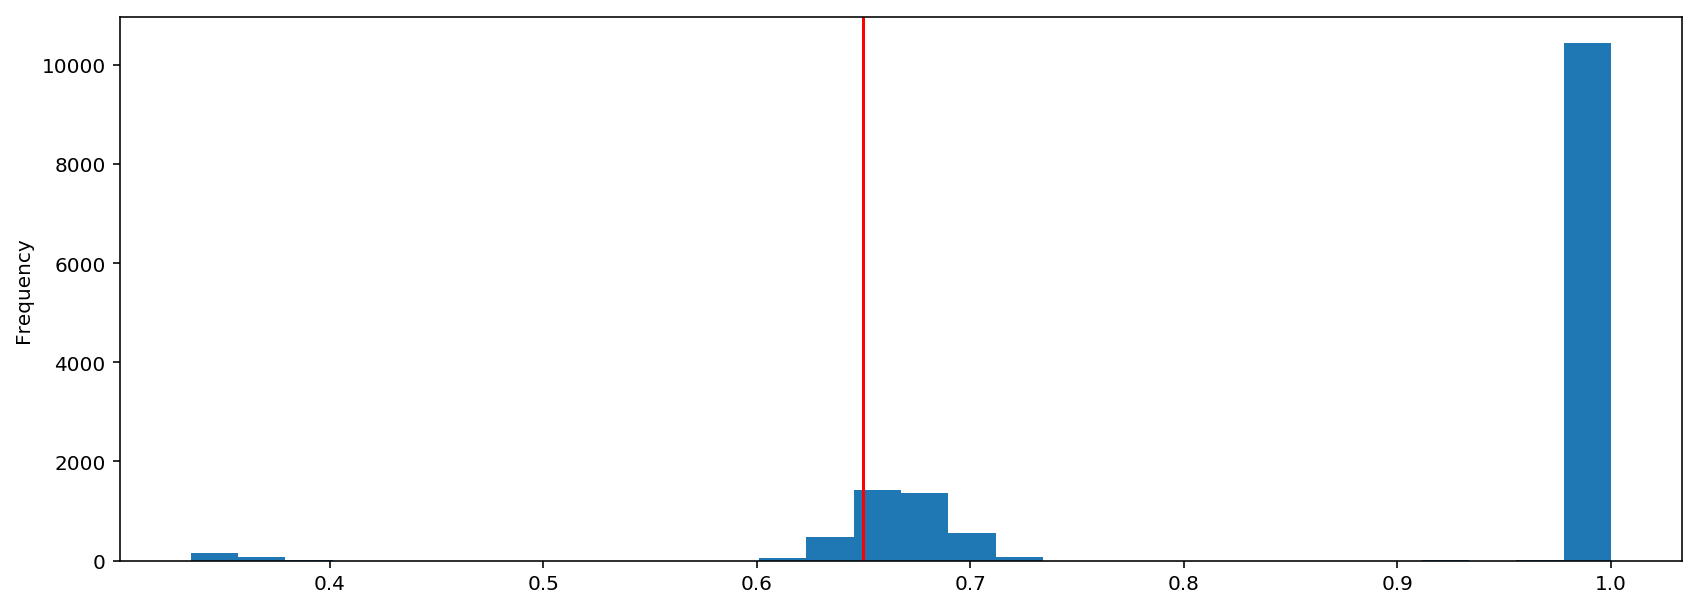

In [6]:
plt.figure(figsize=(14,5))
data['airline_sentiment_confidence'].plot(kind="hist", bins=30)
plt.axvline(x=0.65, color='r', linestyle='-')
plt.show()

In [7]:
data.airline_sentiment_confidence.describe()

count    14640.000000
mean         0.900169
std          0.162830
min          0.335000
25%          0.692300
50%          1.000000
75%          1.000000
max          1.000000
Name: airline_sentiment_confidence, dtype: float64

In [8]:
np.sum(data['airline_sentiment_confidence'] < 0.65)

977

In [9]:
np.sum(data['airline_sentiment_confidence'] < 0.65) / len(data)

0.066734972677595622

In [10]:
data_clean = data.copy()
data_clean = data_clean[data_clean['airline_sentiment_confidence'] > 0.65]

The data is a little bit skewed, with more negative sentiment tweets. There are not missing data for these two variables:

In [11]:
data_clean['airline_sentiment'].value_counts(dropna = False)

negative    8787
neutral     2700
positive    2164
Name: airline_sentiment, dtype: int64

In [12]:
np.sum(data_clean['text'].isnull())

0

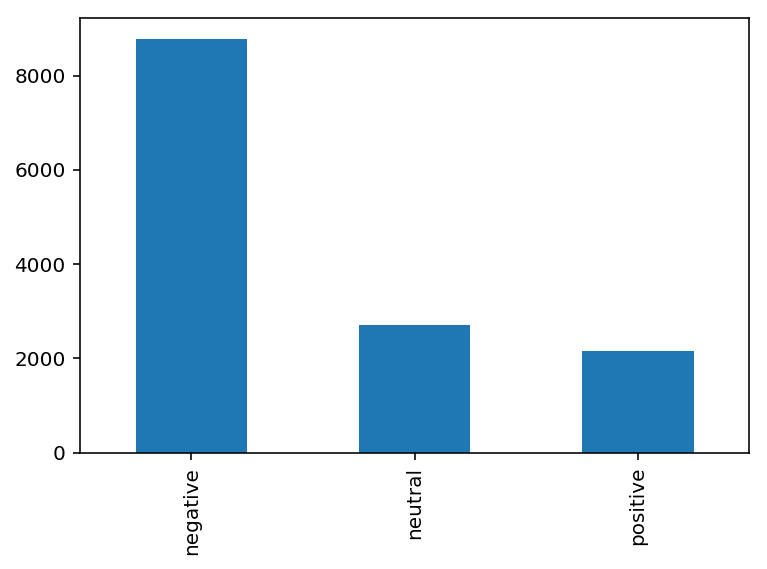

In [13]:
data_clean['airline_sentiment'].value_counts().plot(kind="bar")
plt.show()

Because we are interested in detecting negative tweets vs the others, we will create a variable with two possible values: negative (codified as 1) or non negative (codified as 0):

In [14]:
data_clean['sentiment'] = data_clean['airline_sentiment'].apply(lambda x: 1 if x=='negative' else 0)

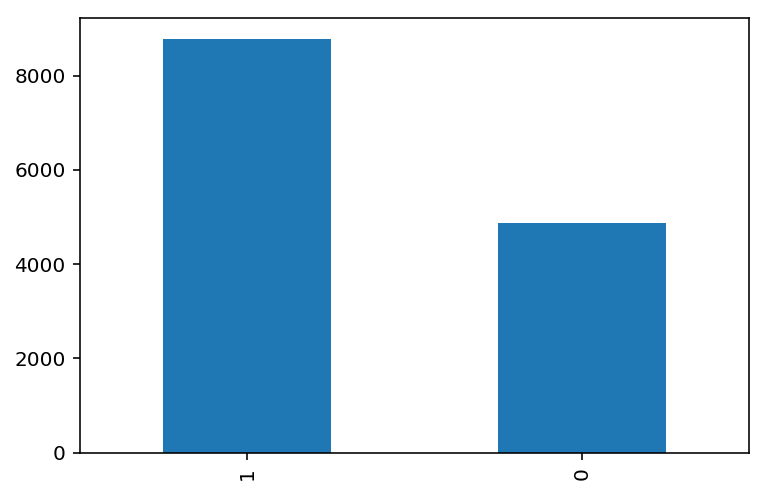

In [15]:
data_clean['sentiment'].value_counts().plot(kind="bar")
plt.show()

In [16]:
data_clean['sentiment'].value_counts()

1    8787
0    4864
Name: sentiment, dtype: int64

In [17]:
tweets_len = data_clean['text'].apply(len)

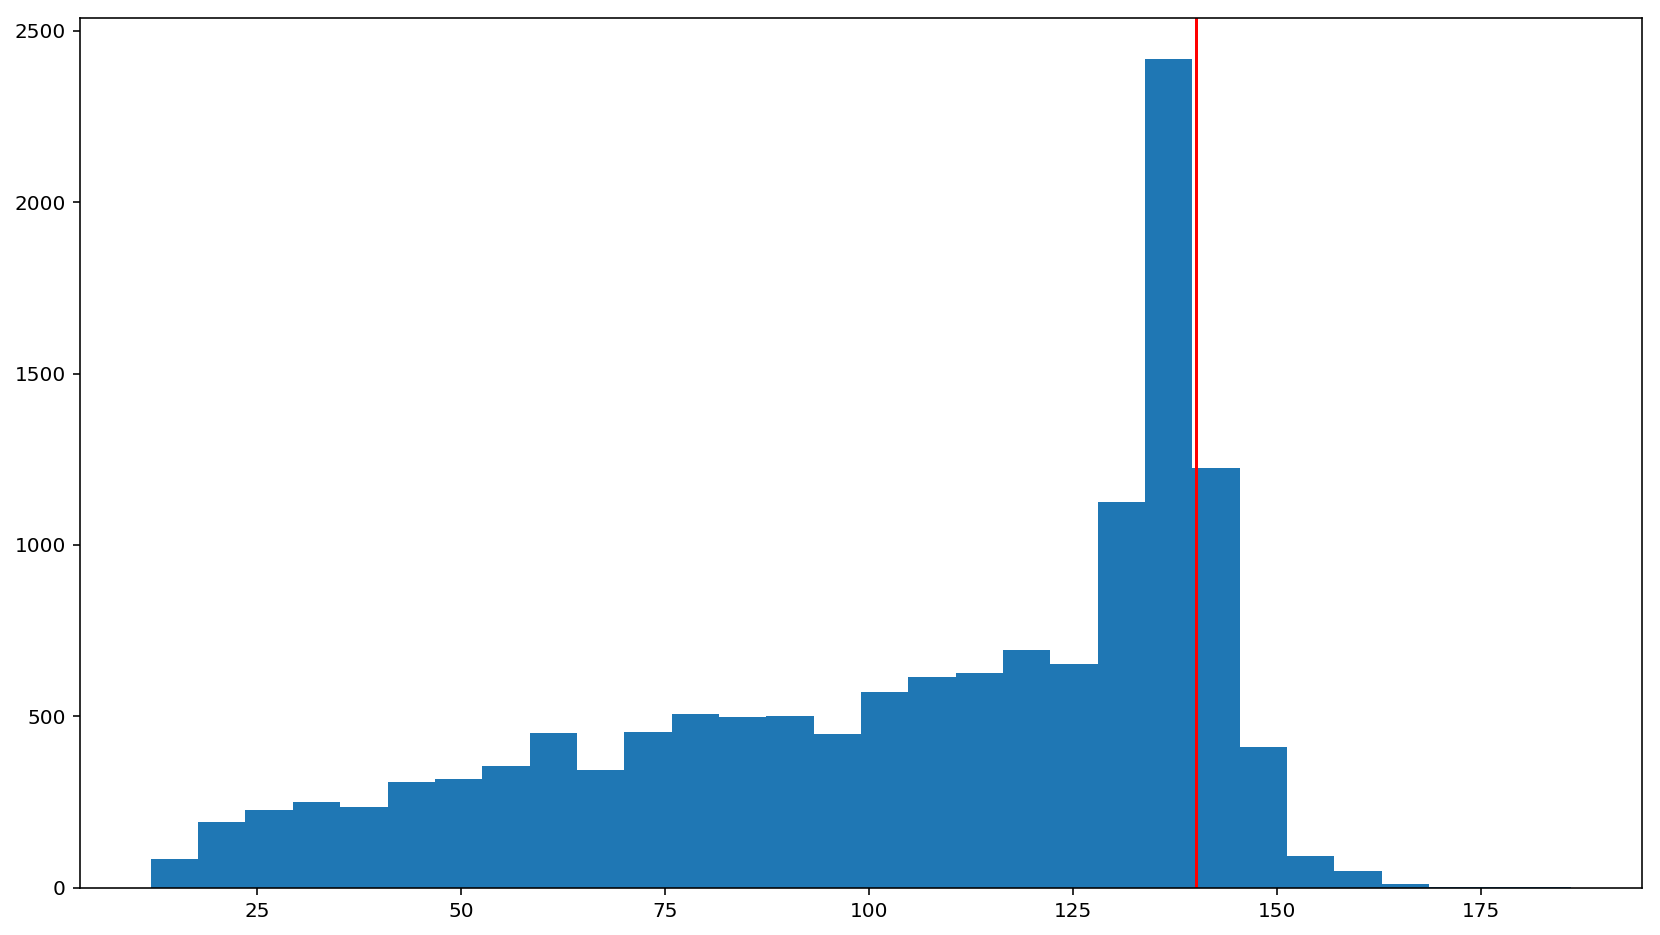

In [18]:
plt.figure(figsize=(14,8))
plt.hist(tweets_len, bins=30)
plt.axvline(x=140, color='r', linestyle='-')
plt.show()

It is a bit strange that some tweets have more than 140 characters, which theoretically is the limit:

In [19]:
print("Mean tweet size: {:.4f} (+/- {:.4f})".format(np.mean(tweets_len), np.std(tweets_len)))

Mean tweet size: 104.4608 (+/- 36.1416)


In [20]:
from scipy import stats
stats.describe(tweets_len)

DescribeResult(nobs=13651, minmax=(12, 186), mean=104.46084535931433, variance=1306.3138331021653, skewness=-0.7124213049119914, kurtosis=-0.6314361320224249)

In [21]:
np.sum(tweets_len > 140)

1011

In [22]:
data_clean.iloc[np.where(tweets_len > 170)].index

Int64Index([10405, 11807], dtype='int64')

In [23]:
data_clean.loc[10405, "text"]

"@USAirways Eyyyy! Cancelled Flightlations, Flight Booking Problemss, reFlight Booking Problemss, but y'all got me on the same flight out tonight (not tomorrow) &amp; the FC upgrade. Thx!"

In [24]:
data_clean.loc[11807, "text"]

'@USAirways Travelling from pwm to atl on Sunday That flight got Cancelled Flightled and my new flight is Cancelled Flightled and got disconnected when reFlight Booking Problems'

We could be conservative and remove all tweets bigger than 140 characters (that would be about 7% of the dataset):

In [25]:
(np.sum(tweets_len > 140)/len(data_clean))*100

7.406050838766391

Exploring some cases we see that sometimes html tags and codifications has been scraped and included in the tweets. That means that these tweets are going to be considered longer that they are in reality. We are going to use a good Twitter tokenizer in the project, so it is going to deal with this problem:  

In [26]:
print(data_clean.iloc[np.where(tweets_len > 160)]['text'])

903      @united FAIL You Cancelled Flightled our fligh...
1075     @united 2 Cancelled Flighted flights Late Flig...
2944     @united United Club team is A+ &amp; got me a ...
4466     @SouthwestAir why was Southwest only airline t...
5069     @SouthwestAir Thx to customer service rep ALEX...
5621     @SouthwestAir#4569 Cancelled Flightled, had to...
6536     @SouthwestAir MCO-&gt;DCA flight almost full o...
6763     @JetBlue Cancelled Flighted my flight. Went wi...
8359     @JetBlue Hey guys! Your Flight Booking Problem...
8916     @JetBlue glitches on website re: Flight Bookin...
9991     @USAirways  you Cancelled Flighted &amp; resch...
10165    @USAirways been on hold 2 hours for a Cancelle...
10405    @USAirways Eyyyy! Cancelled Flightlations, Fli...
10467    @USAirways flt last nght Cancelled Flighted-me...
11665    @USAirways My Flight Booking Problems C68LD9 j...
11807    @USAirways Travelling from pwm to atl on Sunda...
12208    @AmericanAir When Flight Booking Problems an i.

In [27]:
raw_html = data_clean.loc[6536, "text"]
raw_html

"@SouthwestAir MCO-&gt;DCA flight almost full of people screwed by the MSY-DCA Cancelled Flightation. @united and @USAirways didn't Cancelled Flight. SWA=mistake."

In [28]:
from bs4 import BeautifulSoup
cleantext = BeautifulSoup(raw_html, "lxml").text

In [29]:
cleantext

"@SouthwestAir MCO->DCA flight almost full of people screwed by the MSY-DCA Cancelled Flightation. @united and @USAirways didn't Cancelled Flight. SWA=mistake."

In [30]:
from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer()

In [31]:
tknzr.tokenize(raw_html)

['@SouthwestAir',
 'MCO',
 '->',
 'DCA',
 'flight',
 'almost',
 'full',
 'of',
 'people',
 'screwed',
 'by',
 'the',
 'MSY-DCA',
 'Cancelled',
 'Flightation',
 '.',
 '@united',
 'and',
 '@USAirways',
 "didn't",
 'Cancelled',
 'Flight',
 '.',
 'SWA',
 '=',
 'mistake',
 '.']

Because our main goal is to analyze sentiment on text, we are going to keep all the tweets at the moment. Processing html the number of tweets bigger than 140 has been reduced: 

In [32]:
data_clean['text_clean'] = data_clean['text'].apply(lambda x: BeautifulSoup(x, "lxml").text)

In [33]:
BeautifulSoup("@VirginAmerica I &lt;3 pretty graphics. so much better than minimal iconography. :D,0", "lxml").text

'@VirginAmerica I <3 pretty graphics. so much better than minimal iconography. :D,0'

In [34]:
np.sum(data_clean['text_clean'].apply(len) > 140)

739

In [35]:
data_clean['sentiment'].value_counts()

1    8787
0    4864
Name: sentiment, dtype: int64

Let's see some summary statistics for all the tweets:

In [36]:
tweets_clean_len = data_clean['text_clean'].apply(len)

In [37]:
print("Mean tweet size: {:.4f} (+/- {:.4f})".format(np.mean(tweets_clean_len), np.std(tweets_clean_len)))

Mean tweet size: 104.2435 (+/- 35.9762)


In [38]:
tweets_clean_words = data_clean['text_clean'].apply(lambda x: tknzr.tokenize(x.lower()))

In [39]:
tweets_clean_words_num = tweets_clean_words.apply(len)
print("Mean tweet size: {:.4f} (+/- {:.4f})".format(np.mean(tweets_clean_words_num) , np.std(tweets_clean_words_num)))

Mean tweet size: 20.2053 (+/- 7.6421)


In [40]:
stats.describe(tweets_clean_words_num)

DescribeResult(nobs=13651, minmax=(2, 42), mean=20.205332942641565, variance=58.405527601595288, skewness=-0.41579365462924706, kurtosis=-0.7390899725600057)

We are going to see what are the most common words (removing stop words previously)

In [41]:
from nltk.corpus import stopwords
from string import punctuation
en_stopwords = set(stopwords.words("english")) 

In [42]:
airlines_usernames = ['@united', '@usairways', '@americanair', '@southwestair', '@jetblue']

In [43]:
tweets_clean_words_nostop = tweets_clean_words.apply(lambda x: [w for w in x if (w not in en_stopwords) and
                                                               (w not in punctuation)])

In [44]:
tweets_clean_words_nostop_num = tweets_clean_words_nostop.apply(len)
print("Mean tweet size: {:.4f} (+/- {:.4f})".format(np.mean(tweets_clean_words_nostop_num) , 
                                                    np.std(tweets_clean_words_nostop_num)))

Mean tweet size: 10.8109 (+/- 4.1282)


In [45]:
from collections import Counter
word_counter = Counter()

In [46]:
for tweet in tweets_clean_words_nostop:
    for w in tweet:
        word_counter[w] += 1

The more common tokens in all tweets:

In [47]:
word_counter.most_common(30)

[('flight', 3689),
 ('@united', 3622),
 ('@usairways', 2845),
 ('@americanair', 2807),
 ('@southwestair', 2257),
 ('@jetblue', 2054),
 ('get', 1245),
 ('cancelled', 999),
 ('thanks', 966),
 ('...', 941),
 ('service', 928),
 ('help', 792),
 ('time', 735),
 ('customer', 721),
 ('hours', 664),
 ('2', 638),
 ('us', 634),
 ("i'm", 633),
 ('hold', 630),
 ('plane', 597),
 ('flights', 595),
 ('thank', 554),
 ('still', 552),
 ('please', 524),
 ('one', 520),
 ('delayed', 518),
 ('need', 507),
 ("can't", 506),
 ('gate', 493),
 ('would', 491)]

In [48]:
negative_tweet_index = data_clean.loc[data_clean['sentiment']==1].index
positive_tweet_index = data_clean.loc[data_clean['sentiment']==0].index

In [49]:
np.mean(tweets_clean_words_nostop[negative_tweet_index].apply(len))

11.824513485831341

In [50]:
np.mean(tweets_clean_words_nostop[positive_tweet_index].apply(len))

8.979646381578947

In [51]:
mentions_in_positive = []
url_in_positive = []
word_positive_counter = Counter()
for tweet in tweets_clean_words_nostop[positive_tweet_index]:
    mentions = 0
    urls = 0
    for w in tweet:
        word_positive_counter[w] += 1
        if w.startswith('http'):
            urls += 1
        if w[0]=='@':
            mentions += 1   
        mentions_in_positive.append(mentions)  
        url_in_positive.append(urls)

In [52]:
np.mean(url_in_positive)

0.024200380062733246

The more common tokens in non-negative tweets:

In [53]:
word_positive_counter.most_common(20)

[('@jetblue', 1149),
 ('@southwestair', 1114),
 ('@united', 1042),
 ('flight', 890),
 ('@americanair', 766),
 ('thanks', 679),
 ('@usairways', 585),
 ('thank', 481),
 ('get', 305),
 ('@virginamerica', 299),
 ('great', 243),
 ('...', 232),
 ('help', 224),
 ('please', 213),
 ('service', 197),
 ('flights', 193),
 ('us', 176),
 ('time', 162),
 ("i'm", 160),
 ('love', 155)]

In [54]:
mentions_in_negative = []
url_in_negative = []
word_negative_counter = Counter()
for tweet in tweets_clean_words_nostop[negative_tweet_index]:
    mentions = 0
    urls = 0
    for w in tweet:
        word_negative_counter[w] += 1
        if w.startswith('http'):
            urls += 1        
        if w[0]=='@':
            mentions += 1
    mentions_in_negative.append(mentions)    
    url_in_negative.append(urls)

In [55]:
np.mean(url_in_negative)

0.048594514623876178

In [56]:
print("Mean mentions in negative tweets: {:.4f} (+/- {:.4f})".format(np.mean(mentions_in_negative), 
                                                                     np.std(mentions_in_negative)))

Mean mentions in negative tweets: 1.1108 (+/- 0.3655)


In [57]:
print("Mean mentions in non-negative tweets: {:.4f} (+/- {:.4f})".format(np.mean(mentions_in_positive), 
                                                                         np.std(mentions_in_positive)))

Mean mentions in non-negative tweets: 1.0933 (+/- 0.3810)


The more common tokens in negative tweets:

In [58]:
word_negative_counter.most_common(20)

[('flight', 2799),
 ('@united', 2580),
 ('@usairways', 2260),
 ('@americanair', 2041),
 ('@southwestair', 1143),
 ('get', 940),
 ('@jetblue', 905),
 ('cancelled', 879),
 ('service', 731),
 ('...', 709),
 ('hours', 641),
 ('hold', 600),
 ('customer', 592),
 ('time', 573),
 ('help', 568),
 ('2', 552),
 ('plane', 509),
 ('delayed', 489),
 ('still', 473),
 ("i'm", 473)]

We save the clean dataset:

In [59]:
data_clean.to_csv('../output/data_clean.csv',
                  columns=['text_clean', 'sentiment'],
                  header=['text', 'sentiment'],
                  index=False)